In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# We load the dataset from a CSV file
path_to_dataset = r"C:\Users\dkg14\Desktop\AAP_data.csv"
df = pd.read_csv(path_to_dataset)


In [3]:
# We drop columns that are not needed
df = df.drop(columns=['Name', 'date'])

# We drop NaN values if any
df = df.dropna()

print(df.head())


    open   high      low  close   volume
0  78.34  79.72  78.0100  78.90  1298137
1  78.65  78.91  77.2300  78.39   758016
2  78.39  78.63  77.5132  78.60   876859
3  78.90  79.13  77.8500  78.97  1038574
4  78.66  79.72  78.5850  78.84  1005376


In [4]:
# We convert DataFrame to NumPy array
data = df.to_numpy()

# We normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# We split into train, validation, and test sets
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.1)
train, val, test = scaled_data[:train_size], scaled_data[train_size:train_size + val_size], scaled_data[train_size + val_size:]


In [10]:
# We define window length and create sequences for training
window_length = 15
trainX, trainY = [], []
for i in range(len(train) - window_length - 1):
    trainX.append(train[i:i + window_length])
    trainY.append(train[i + window_length, 3])  # Assuming 'close' price is the target

trainX, trainY = np.array(trainX), np.array(trainY)

valX, valY = [], []
for i in range(len(val) - window_length - 1):
    valX.append(val[i:i + window_length])
    valY.append(val[i + window_length, 3])  # Assuming 'close' price is the target
valX, valY = np.array(valX), np.array(valY)

testX, testY = [], []
for i in range(len(test) - window_length - 1):
    testX.append(test[i:i + window_length])
    testY.append(test[i + window_length, 3])  # Assuming 'close' price is the target
testX, testY = np.array(testX), np.array(testY)


In [11]:
# We reshape the data for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

# We make and train the model
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
print("BEGINNING TRAINING")

model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2, validation_data=(valX, valY))

print("TRAINING COMPLETE")

BEGINNING TRAINING
Epoch 1/50
865/865 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 2/50
865/865 - 2s - 2ms/step - loss: 0.0011 - val_loss: 9.0131e-04
Epoch 3/50
865/865 - 2s - 2ms/step - loss: 8.2813e-04 - val_loss: 7.7125e-04
Epoch 4/50
865/865 - 2s - 2ms/step - loss: 8.1930e-04 - val_loss: 0.0019
Epoch 5/50
865/865 - 2s - 2ms/step - loss: 6.9320e-04 - val_loss: 9.4410e-04
Epoch 6/50
865/865 - 2s - 2ms/step - loss: 6.2038e-04 - val_loss: 6.4928e-04
Epoch 7/50
865/865 - 2s - 2ms/step - loss: 6.1661e-04 - val_loss: 6.5857e-04
Epoch 8/50
865/865 - 2s - 2ms/step - loss: 5.5017e-04 - val_loss: 0.0035
Epoch 9/50
865/865 - 2s - 2ms/step - loss: 5.5348e-04 - val_loss: 6.5946e-04
Epoch 10/50
865/865 - 2s - 2ms/step - loss: 5.7116e-04 - val_loss: 7.3702e-04
Epoch 11/50
865/865 - 2s - 2ms/step - loss: 5.2482e-04 - val_loss: 5.3784e-04
Epoch 12/50
865/865 - 2s - 2ms/step - loss: 5.2032e-04 - val_loss: 5.5858e-04
Epoch 13/50
865/865 - 2s - 2ms/step - loss: 5.0895e-04 - val_loss: 5.3704e

In [13]:
# We produce Training predictions using the model
training_predictions = model.predict(trainX)

# We apply the inverse transform on the predictions and the true values
train_predictions_inversed = scaler.inverse_transform(np.concatenate((trainX[:, -1, :-1], training_predictions.reshape(-1, 1)), axis=1))[:, -1]
trainY_inversed = scaler.inverse_transform(np.concatenate((trainX[:, -1, :-1], trainY.reshape(-1, 1)), axis=1))[:, -1]

# We calculate the Mean Squared Error for training data
training_MSE = mean_squared_error(trainY_inversed, train_predictions_inversed)
print('Training MSE: %.10f' % training_MSE)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Training MSE: 155085471191.8092041016


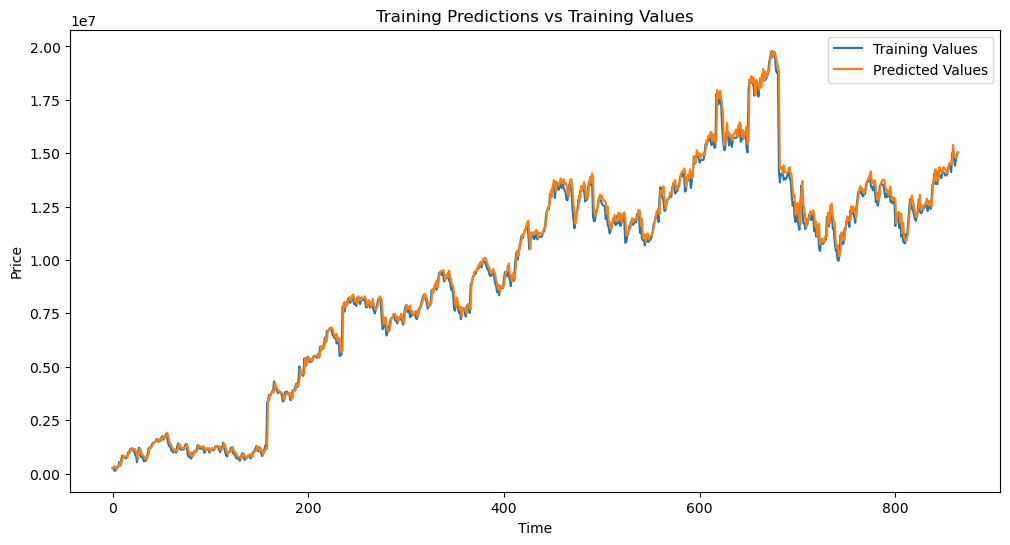

In [17]:
# We plot the training predictions against the training values
plt.figure(figsize=(12, 6))
plt.plot(trainY_inversed, label='Training Values')
plt.plot(train_predictions_inversed, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Training Predictions vs Training Values')
plt.legend()
plt.show()


In [15]:
# We produce Validation predictions using the model
val_predictions = model.predict(valX)

# We apply the inverse transform on the predictions and the true values
val_predictions_inversed = scaler.inverse_transform(np.concatenate((valX[:, -1, :-1], val_predictions.reshape(-1, 1)), axis=1))[:, -1]
valY_inversed = scaler.inverse_transform(np.concatenate((valX[:, -1, :-1], valY.reshape(-1, 1)), axis=1))[:, -1]

# We calculate Mean Squared Error for validation data
val_MSE = mean_squared_error(valY_inversed, val_predictions_inversed)
print('Validation MSE: %.10f' % val_MSE)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation MSE: 241755845718.0626220703


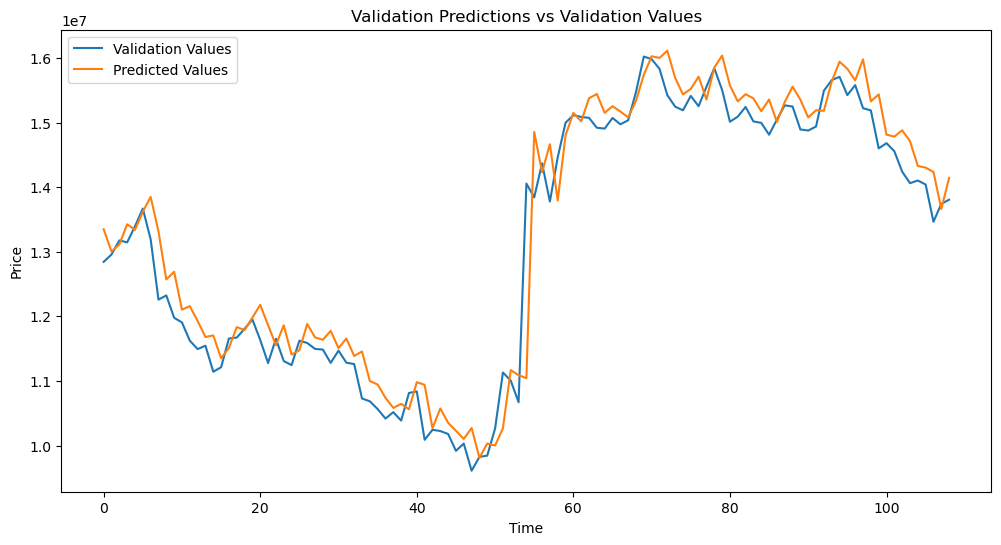

In [18]:
# We plot the validation predictions against the validation values
plt.figure(figsize=(12, 6))
plt.plot(valY_inversed, label='Validation Values')
plt.plot(val_predictions_inversed, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Validation Predictions vs Validation Values')
plt.legend()
plt.show()

In [20]:
# We generate test predictions using the model
test_predictions = model.predict(testX)

# We apply the inverse transform the predictions and the true values
test_predictions_inversed = scaler.inverse_transform(np.concatenate((testX[:, -1, :-1], test_predictions.reshape(-1, 1)), axis=1))[:, -1]
testY_inversed = scaler.inverse_transform(np.concatenate((testX[:, -1, :-1], testY.reshape(-1, 1)), axis=1))[:, -1]

# We calculate Mean Squared Error for test data
test_MSE = mean_squared_error(testY_inversed, test_predictions_inversed)
print('Test MSE: %.10f' % test_MSE)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test MSE: 228876418994.2568969727


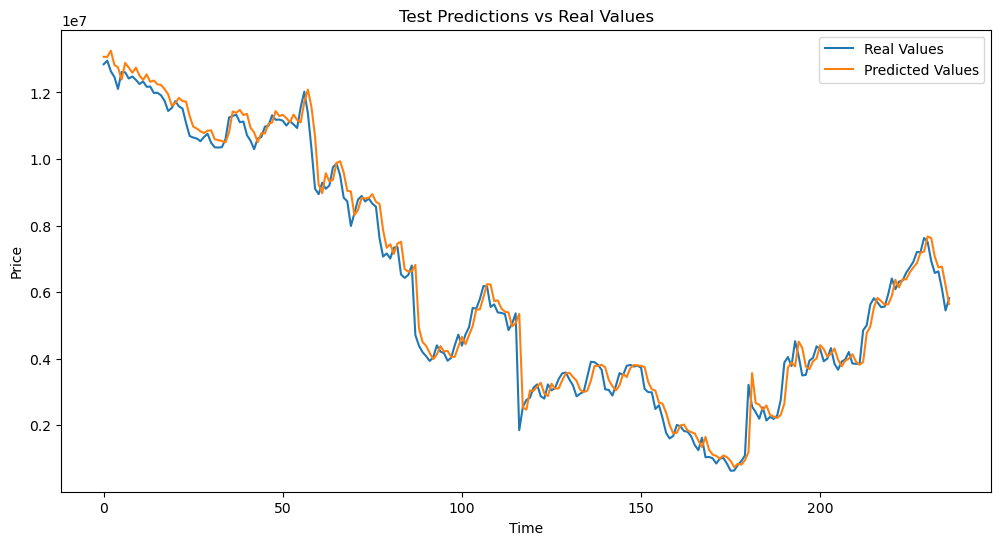

In [21]:
# We plot the test predictions against the test values
plt.figure(figsize=(12, 6))
plt.plot(testY_inversed, label='Real Values')
plt.plot(test_predictions_inversed, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Test Predictions vs Real Values')
plt.legend()
plt.show()

In [24]:
# We calculate accuracy of predicting the stock's movement direction
Z = 0
for j in range(len(testY_inversed) - 1):
    if (test_predictions_inversed[j + 1] - test_predictions_inversed[j] > 0 and testY_inversed[j + 1] - testY_inversed[j] > 0) or \
       (test_predictions_inversed[j + 1] - test_predictions_inversed[j] < 0 and testY_inversed[j + 1] - testY_inversed[j] < 0):
        Z += 1

acc = Z / (len(testY_inversed) - 1)


In [25]:
acc = Z / (len(testY_inversed) - 1)

print("Below is the accuracy in predicting the stock's movement:")
print(acc)

Below is the accuracy in predicting the stock's movement:
0.5423728813559322
